In [1]:
import numpy as np

##my stuff
from imagery_psychophysics.src.stirling_maps import sparse_point_maps as spm
from imagery_psychophysics.src.model_z import noise_grid
from mpl_toolkits.axes_grid1 import ImageGrid

##other stuff
from matplotlib.colors import LinearSegmentedColormap
from scipy.misc import comb as nCk
from time import time
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function, shared
from theano.tensor.extra_ops import repeat, to_one_hot
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


## Refining the procedures for CAVI (coordinate ascent variational inference).
Here I simplified the code for variational inference and corrected the very wrong thing about the previous attempt.

### Theano expressions

In [2]:
floatX = 'float32'

#### Generate samples of object maps from a posterior over object maps

In [3]:
##the variational posterior over object maps Z
_Q_Z = T.matrix('Q_Z')            ##(K,D)
_M = T.scalar('M',dtype='int32')

##a theano random number generator
rng = MRG_RandomStreams(use_cuda = True)

##sample one Z map from posterior Q_Z
_Z_samples = rng.multinomial(pvals = repeat(_Q_Z.T,_M,axis=0)).reshape((_Q_Z.shape[1],_M,_Q_Z.shape[0])).dimshuffle((1,2,0))

#### Object count probabilities (was previously calling this "object responsibility" because I vaguely remembered this type of jargon from studying EM).

In [4]:
##block of sampled object maps
_Z = T.tensor3('Z') ##(M x K x D)

##window index indicator (N X D)
_W = T.matrix('windows')


An expression for an (M,N) matrix of objects counts. Each row provides the object count in each window for one of the M object map samples in Z.

In [5]:
##(M x K x 1 x D)
##         N x D
##(M x K x N x D)  sum(D)
##(M x K x N)      clip(0,1)
##(M x K x N)      sum(K)
##(M x N)
_object_counts = T.sum(_Z.dimshuffle((0,1,'x',2))*_W,axis=-1).clip(0,1).sum(axis=1)

Now apply one-hot-encoding and sum across samples and divide to obtain object count probabilities 

In [6]:
##number of objects theano variable
_K = T.scalar('objects',dtype='int32')

##non-normalized object count probs
_object_count_prob_nn = to_one_hot(_object_counts.astype('int32').flatten()-1,_K).reshape((_object_counts.shape[0],_object_counts.shape[1],_K)).sum(axis=0)

##object count probs (N x K)
_object_count_prob = _object_count_prob_nn / _object_count_prob_nn.sum(axis=1).reshape((_object_count_prob_nn.shape[0], 1))

#### Update variational posterior for one pixel

This will be the only update that returns a normalized variational posterior.
Uses the object_count_prob matrix above.  
Uses a place-holder for log-loglihood (lnP_star)

In [7]:
##K x N x K tensor of object probs
##the first K is object id, the last K is object count
_oc_probs = T.tensor3('oc_probs') 

##N x K, this will just be the log of P_star
_lnP_star = T.matrix('lnP_star')

## K x 1, this is place holder for the dot product between pixel value and expected log of hyperparameters pi
_v = T.matrix('prior_penalties')

      ##K x N x K oc_probs
##(tensordot)
          ##N x K lnP_star 
      ##K x 1     lnQ_z
##(add V)
      ##K x 1
##(exp)
      ##K x 1     Q_z_nn
##(normalize)
      ##K x 1     Q_z, the variational posterior element for one pixel

##log of Q_z (minus unknown constant that normalizes things)    
_lnQ_z = T.tensordot(_oc_probs, _lnP_star, [[1,2], [0,1]]).dimshuffle([0,'x'])+_v

##non-normalized Q_z. we shift by max value to stabilize upcoming exp
_Q_z_nn = T.exp(_lnQ_z-T.max(_lnQ_z)) 

##variational posterior prob for one pixel
_Q_z = _Q_z_nn / _Q_z_nn.sum()

#### Update rule for the variational log posterior over theta (i.e., the noise parameters).
We calculate $ln[q(\theta)] - const$  
We use max of the above for calculating the ELBO.  
We use argmax of the above for updating the variational posteriors


In [8]:
_P_theta = T.tensor3('P_theta') ##(G x N x K)
_X = T.matrix('oc_prob_dummy') ##N x K ~ this is a place holder for the "object count prob" matrix
_lkhd_param_grid = T.matrix('lkhd_param_grid') ## G x 2 grid of candidate noise parameters. we must supply.

##(G x N x K)
##(    N x K)  (dot product, broadcast across G)
##(G x 1)  --> because we don't do vectors we reshape to make output 2Dimensional (G x 1)

##ln q(theta+, theta-) - const (G x 1)
_lnQ_theta = T.tensordot(T.log(_P_theta),_X, axes=[[1,2], [0,1]],).reshape((_P_theta.shape[0], 1))

##find index of the best lkhd params (scalar integer)
_theta_star_idx = T.argmax(_lnQ_theta)

#N x K (windows x object counts)
_P_star = _P_theta[_theta_star_idx,:,:]

#1 x 2 best likelihood params
_theta_star = _lkhd_param_grid[_theta_star_idx,:]

#### Prior over object maps
The hyperparameter $\pi$ is prior over object sizes. It is Dirichlet distributed.  
We need $\mathbb{E}[ln[\pi]]$ to update Q_z. We'll also need it to calculate the ELBO.

In [9]:
_alpha_0 = T.scalar('alpha_0')
_q_Z = T.matrix('q_Z')  ##K x 1, this is result of summing over pixels in Q_Z matrix. very different from Q_z

_alpha = _q_Z + _alpha_0 ##broadcasts the scalar _alpha_0 across K

##(K x 1) this is needed to update Q_z
_Eln_pi = T.psi(_alpha) - T.psi(_alpha.sum())

##(K x 1) not needed for update of variational posteriors, but we'll want it for model interpretation
_E_pi = _alpha / _alpha.sum()

#### Expressions for the ELBO
This is an approximate ELBO because:  
1. We are using a $ln[P^*]$ instead $\mathbb{E}[ln[P^*]]$  
2. We approximate object count probabilities by sampling $M$ object maps from $Q_Z$ and computing a histogram

In [10]:
_Eln_pi_holder = T.matrix('Eln_pi_holder')  ##K x 1 place-holder for _Eln_pi

_lnQ_theta_star = T.scalar('lnQ_theta_star') ##scalar

_Q_Z_holder = T.matrix('Q_Z_holder') ##N x K 

##this is just like q_Z, but we need a different variable name to simplify the computation graph
_like_q_Z = _Q_Z_holder.sum(axis=1,keepdims=True)

##scalar
_prior_entropy = -(T.tensordot(_like_q_Z-1, _Eln_pi_holder)-(T.gammaln(_like_q_Z.sum()) - T.sum(T.gammaln(_like_q_Z))))

##scalar
a_min = 10e-15
a_max = 1
_posterior_entropy = -T.tensordot(_Q_Z_holder.clip(a_min,a_max), T.log(_Q_Z_holder.clip(a_min,a_max)))

##scalar
_badness_of_fit = -_lnQ_theta_star

##scalar
_ELBO = -_badness_of_fit  - _posterior_entropy - _prior_entropy

### Theano functions

#### Generate M samples of object maps from a variational posterior over all pixels, Q_Z

In [11]:
##returns M x K x D (samples x object ids x pixels)
Z_sample_func = function([_Q_Z,_M],outputs=_Z_samples)

#### Estimate object count probabilities from a stack of object map samples Z (given windows W)

In [12]:
##returns N x K (windows x object counts)
object_count_prob_func = function([_Z, _W, _K], outputs = _object_count_prob)

#### Update variational posterior for one pixel

In [13]:
##returns K x 1 (objects ids x 1)
Q_z_update_func = function([_oc_probs, _lnP_star, _v], outputs = _Q_z)

#### Update likelihood parameters (returns $\Theta^*$ and $P^*$, but not $q(\theta_+, \theta_-)$)

In [14]:
##returns theta_star ~ (1 x 2) best lkhd params
##returns P_star (N x K) (windows x object counts)
##return lnQ_theta G x 1
lkhd_update_func = function([_P_theta, _X, _lkhd_param_grid], outputs = [_theta_star, _P_star, _lnQ_theta])

#### Update $\mathbb{E}[ln[\pi]]$ and $\mathbb{E}[\pi]$

In [15]:
##returns _Eln_pi (K x 1) (object ids x 1)
##returns _E_pi (K x 1) (object ids x 1)
prior_update_func = function([_q_Z, _alpha_0], outputs = [_Eln_pi, _E_pi])

#### Calculate the ELBO

In [16]:
## returns four scalars. ELBO is last
ELBO_update_func = function([_Eln_pi_holder, _Q_Z_holder, _lnQ_theta_star], outputs=[_badness_of_fit, _prior_entropy, _posterior_entropy, _ELBO])

### The likelihood function
A note on jargon/notation: p_on, p_off = theta_+, theta_- = likelihood parameters = noise parameters

In [17]:
##helper
def counts(r,d,n):
    return np.array([nCk(d,m)*nCk(n-d, r-m) for m in range(min(r,d)+1)])

##the strange likelihood I derived for this model
#
def lkhd(r,d,n,p_on,p_off):
    probs = np.array([(1-p_on)**(d-m) * (p_on)**m * (p_off)**(r-m) * (1-p_off)**(n-d-r+m) for m in range(min(r,d)+1)])
    #print probs
    return counts(r,d,n).dot(probs)

##create a stack of data likelihood tables for different values of the noise params 
def lkhd_grid(observed_responses, theta_dns, K):
    p_on, p_off = noise_grid(theta_dns,theta_dns)
    N = observed_responses.shape[0]
    G = len(p_on)
    P_theta = np.zeros((G, N, K),dtype=floatX)
    for g,p in enumerate(zip(p_on,p_off)):
        for n in range(N):
            for k in range(K):
                P_theta[g,n,k]  = lkhd(observed_responses[n].squeeze(),k+1,K, p[0],p[1])
    lkhd_param_grid = np.array([p_on,p_off])
    return P_theta, lkhd_param_grid

### Simulated data
Generate windows W (N x D), target object map test_Z (K x D), and simulated responses observed_responses (N x 1)

In [64]:
sqrt_D = 16
D = int(sqrt_D*sqrt_D)#number of pixels
K = 2#number of objects


p_on = 0.9
p_off = 0.1

#### Design windows. These are square windows and pairs of square windows of various sizes.

In [82]:
##construct windows W ~ (N x D)
scales = np.array([1])
stride = 1
sizes = [1] #scales/2
Windows = []
for sz in sizes:
    scale_count = 0
    for rows in np.arange(sz,sqrt_D,stride,dtype=int, ):
        for cols in np.arange(sz,sqrt_D,stride,dtype=int):
            one_win = np.zeros((sqrt_D,sqrt_D),dtype=floatX)
            one_win[(rows-sz):(rows+sz), (cols-sz):(cols+sz)]=1
            Windows.append(one_win)
            scale_count +=1
    print scale_count


N = len(Windows)
n_groups = 3*D
group_order = 2
W = np.zeros((N+n_groups,D),dtype=floatX)
for n in range(N):
    W[n,:] = Windows.pop().ravel()

for n in range(N,N+n_groups):
    rand_pairs = np.random.permutation(N)[:group_order]
    W[n,:] = np.clip(np.sum(W[rand_pairs[0:group_order],:],axis=0), 0, 1)

W = W[N:(N+n_groups),:]
    
    
N = W.shape[0]
print N

225
768


#### Construct a target object map

In [83]:
##construct a test object map
test_object_map = spm(3,3,sqrt_D,cluster_pref = 'random',number_of_clusters = K)
test_object_map.scatter()
test_object_map = np.squeeze(test_object_map.nn_interpolation())

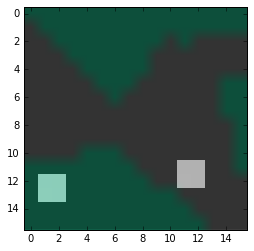

In [84]:
plt.imshow(test_object_map, cmap='Dark2')
plt.imshow(W[-1].reshape((sqrt_D,sqrt_D)).astype('uint8')*255, interpolation='none', alpha = .5, cmap=plt.cm.gray, clim=[0,255])

In [85]:
##convert to one_hot encoding
test_Z = np.eye(K)[test_object_map.ravel()-1].T  ##K x D
d = 5
print test_object_map[d,d]
print test_Z.reshape((K,sqrt_D,sqrt_D))[:,d,d]

1
[ 1.  0.]


#### Generate simulated responses

In [86]:
##get true object counts for each window
object_counts = np.sum(test_Z[:,np.newaxis,:]*W,axis=-1).clip(0,1).sum(axis=0).astype('int')
object_counts[-1]

2

In [87]:
##generate some fake responses using fixed theta parameters

observed_responses = np.zeros((object_counts.shape[0], 1), dtype = 'int')
for ii,o in enumerate(object_counts):
    resp_dist = np.zeros(K)
    for k in range(K):
        resp_dist[k] = lkhd(k+1,o,K,p_on,p_off)
    observed_responses[ii]=np.argmax(np.random.multinomial(1,resp_dist))+1


(array([ 281.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  487.]),
 array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ]),
 <a list of 10 Patch objects>)

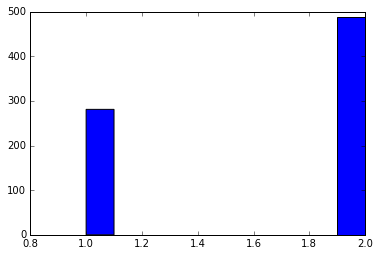

In [88]:
plt.hist(observed_responses)

In [26]:
observed_responses.shape

(900, 1)

### Tests

### CAVI loop

#### Initialization

In [27]:
def init_Q_Z(dirichlet_param, K, D):
    Q_Z = np.zeros((K,D), dtype=floatX)
    probs = np.random.dirichlet([dirichlet_param]*K,)
    for d in range(D): #np.random.permutation(D):
        Q_Z[:,d] = probs
    return Q_Z

In [28]:
def init_Eln_pi(Q_Z, dirichlet_param):
    q_Z = Q_Z.sum(axis=1, keepdims=True) ##a fake q_Z, should be K x 1
    Eln_pi, _ = prior_update_func(q_Z, dirichlet_param)
    return Eln_pi

In [29]:
def init_P_star(observed_responses, theta_plus, theta_minus, K):
    N = observed_responses.shape[0]
    observed_responses = np.squeeze(observed_responses)
    P_star = np.zeros((N,K),dtype=floatX)
    for n in range(N):
        for k in range(K):
            P_star[n,k]  = lkhd(observed_responses[n],k+1,K, theta_plus,theta_minus)
    return P_star

#### Visualization

In [30]:
##visualize the variational posterior over pixels
def see_Q_Z(Q_Z, target_object_map = None):
    ##view: construct an image grid
    fig = plt.figure(1, (30,10))
    K = Q_Z.shape[0]
    if target_object_map is not None:
        K += 1
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    if target_object_map is not None:
        im = grid[0].imshow(target_object_map,cmap='Dark2')
        grid[0].cax.colorbar(im)
        for kk in range(1,K):
            im = grid[kk].imshow(Q_Z[kk-1], cmap='hot', clim=[0,1])
            grid[kk].cax.colorbar(im)

    else: 
        for kk in range(0,K):
            im = grid[kk].imshow(Q_Z[kk], cmap='hot', clim=[0,1])
            grid[kk].cax.colorbar(im)

In [31]:
##this will help visualize samples from Q_Z
def see_Z_sample(Z,sqrt_D,axis=0,show=True):
    '''
    Z ~ K x D
    convert to 1 x D, D[i] = j, j = argmax(Z[:,i])
    '''
    Z_image = np.argmax(Z,axis=axis).reshape(np.sqrt(D),np.sqrt(D))
    if show:
        ax = plt.pcolor(Z_image,cmap='Dark2')
        plt.axes().set_aspect('equal', 'datalim')
    return Z_image


In [32]:
##object confusion matrix, sort of
##for each object, calculate the log-prob under the variational posterior for each class. return. display
def object_confusion(Q_Z, Z, show=False):
    '''
    log_prob_kj = (K x K) log-prob of class k in Q_Z given object j in object map Z
    '''
    K = Z.shape[0]
    log_prob = np.zeros((K,K))
    for k in range(K):
        for j in range(K):
            log_prob[k,j] = np.sum(np.log(Q_Z[k].clip(10e-15,1))*Z[j])
    
    if show:
        plt.pcolor(log_prob, cmap='gray')
        plt.axes().set_aspect('equal', 'datalim')
        plt.colorbar()
    return log_prob

def see_posterior_overlay(Q_Z, Z):
    '''
    Q_Z ~ K x D
      Z ~ K x D
    '''
    ##view: construct an image grid
    fig = plt.figure(1, (40,20))
    K = Q_Z.shape[0]
    sqrt_D = int(np.sqrt(Q_Z.shape[1]))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    
    colors = [(0, 0, 0), (1., 1., 0)]
    cm_1 = LinearSegmentedColormap.from_list(
        'object_map', colors, N=2)

    colors = [(0, 0, 0), (0., 0., 1.)]
    cm_2 = LinearSegmentedColormap.from_list(
        'prob', colors, N=20)

    
    log_prob = object_confusion(Q_Z, Z)
    Q_Z = Q_Z.reshape((K, sqrt_D, sqrt_D))
    Z = Z.reshape((K, sqrt_D, sqrt_D))
    for k in range(K):
        
        max_k,max_j = np.unravel_index(np.argmax(log_prob), log_prob.shape)
        log_prob[max_k,:] = -np.inf
        log_prob[:,max_j] = -np.inf
        grid[k].imshow(Z[max_j],cmap=cm_1)
        grid[k].imshow(Q_Z[max_k], cmap=cm_2, clim=[0,1], alpha = 0.6)
        
    
    
    
            

#### Main

In [91]:
##initial randomness: controls randomness of each pixel's Q_z
alpha_0 = 4.1

##initial guess noise params
theta_plus, theta_minus = p_on, p_off

##density of sampling grid of lkhd params
theta_dns = 25 

##number of samples from Q_Z per update
M = 700#number of object map samples to generate for calculating object responsibility

##K x D
Q_Z = init_Q_Z(alpha_0, K, D)

##N x K
P_star = init_P_star(observed_responses, theta_plus, theta_minus, K)

##K x 1
Eln_pi = init_Eln_pi(Q_Z, alpha_0)

##G x N x K
P_theta = P_star[np.newaxis,:,:]
lkhd_param_grid = np.array([theta_plus, theta_minus], dtype=floatX, ndmin=2)
# P_theta, lkhd_param_grid = lkhd_grid(observed_responses, theta_dns, K)

##other scalars
delta_ELBO = np.inf
t = 0
max_t = 20
min_delta_ELBO = 10e-10
ELBO_old = 0.
ELBO_history = np.zeros((max_t,1))

while (delta_ELBO > min_delta_ELBO) and (t < max_t):
    
    ##put lkhd in log domain
    lnP_star = np.log(P_star).astype(floatX)
    
    ##coordinate ascent on variational posteriors of object map pixels
    for d in range(D):
        Z = Z_sample_func(Q_Z, M).astype(floatX)  ##M x K x D
        oc_probs = np.zeros((K, N, K),dtype=floatX)
        v = np.zeros((K,1), dtype=floatX)
        for k in range(K): 
            Z[:,:,d] = 0.    ##clear out object assignment for pixel d
            Z[:,k, d] = 1.   ##assign pixel d to object k
            oc_probs[k,:,:] = object_count_prob_func(Z, W, K) ##calculate object count probs. given this assignment
            v[k] = np.dot(Z[0,:,d], Eln_pi,)               ##compare current assignment to prior over assignments
        Q_Z[:, d] = Q_z_update_func(oc_probs, lnP_star, v).squeeze() ##update variational posterior for pixel d
    
    ##update lkhd params
    Z = Z_sample_func(Q_Z, M).astype(floatX)
    oc_probs = object_count_prob_func(Z, W, K)
    theta_star, P_star, lnQ_theta = lkhd_update_func(P_theta, oc_probs, lkhd_param_grid)
    
    ##update prior params
    q_Z = Q_Z.sum(axis=1, keepdims=True)
    Eln_pi, E_pi = prior_update_func(q_Z, alpha_0)
    
    ##calculate ELBO
    badness_of_fit, prior_entropy, posterior_entropy, ELBO_history[t] = ELBO_update_func(Eln_pi, Q_Z, lnQ_theta.max())
    
    ##update convergence criteria
    delta_ELBO = np.abs(ELBO_history[t]-ELBO_old)
    ELBO_old = ELBO_history[t]
    print '===========ELBO: %f' %(ELBO_old)
    print 'badness of fit: %f' %(badness_of_fit)
    print 'prior_entropy: %f' %(prior_entropy)
    print 'posterior_entropy: %f' %(posterior_entropy)
    t += 1
ELBO = ELBO_history[:t-1]


===========ELBO: -1019.754395
badness of fit: 566.943481
prior_entropy: 336.613251
posterior_entropy: 116.197662
===========ELBO: -1023.155273
badness of fit: 559.917725
prior_entropy: 330.763062
posterior_entropy: 132.474518
===========ELBO: -988.094360
badness of fit: 546.529663
prior_entropy: 320.022797
posterior_entropy: 121.541954
===========ELBO: -936.996826
badness of fit: 523.766418
prior_entropy: 309.203949
posterior_entropy: 104.026497
===========ELBO: -892.627563
badness of fit: 504.900116
prior_entropy: 298.512329
posterior_entropy: 89.215118
===========ELBO: -853.624390
badness of fit: 490.085236
prior_entropy: 287.504395
posterior_entropy: 76.034775
===========ELBO: -823.379639
badness of fit: 476.774597
prior_entropy: 280.924408
posterior_entropy: 65.680672
===========ELBO: -796.300415
badness of fit: 464.748688
prior_entropy: 274.542480
posterior_entropy: 57.009243
===========ELBO: -782.101257
badness of fit: 459.359741
prior_entropy: 270.513123
posterior_entropy: 52.22

In [92]:
E_pi

array([[ 0.78547353],
       [ 0.21452637]], dtype=float32)

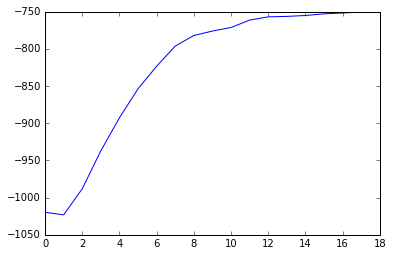

In [93]:
plt.plot(ELBO)

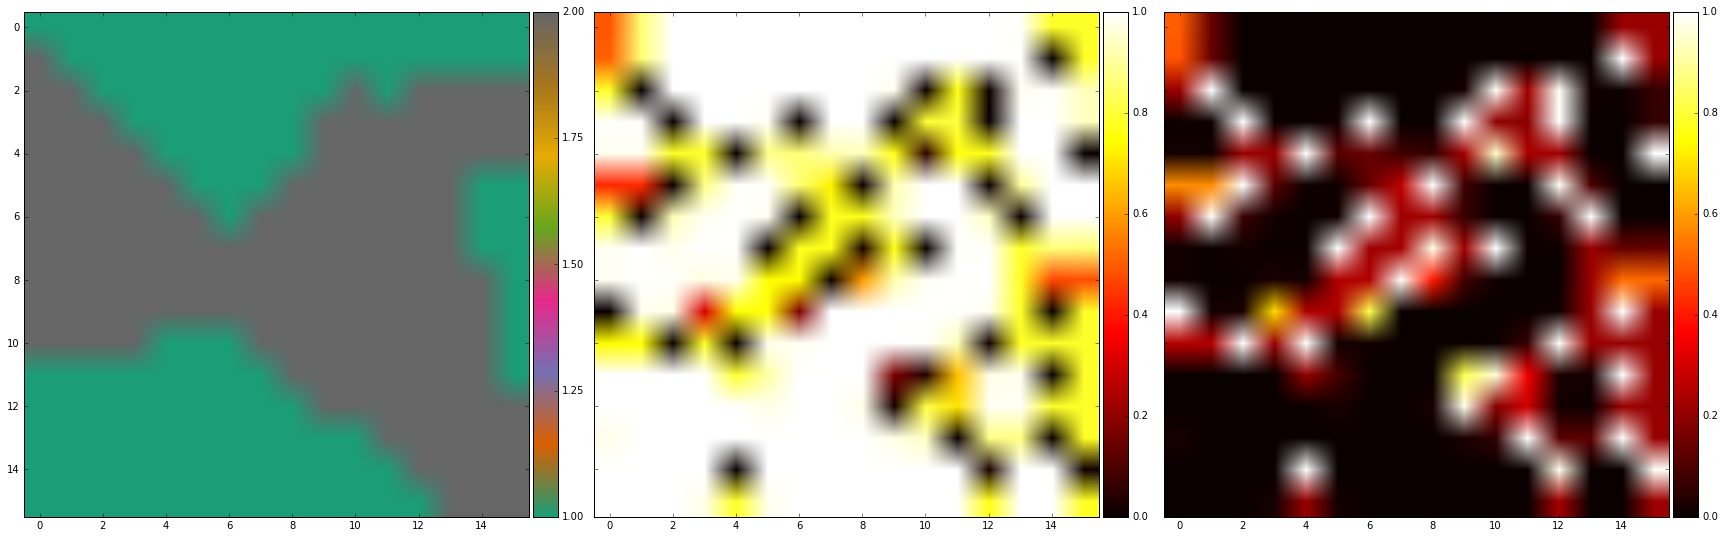

In [94]:

see_Q_Z(Q_Z.reshape((K,sqrt_D,sqrt_D)), target_object_map = test_object_map)


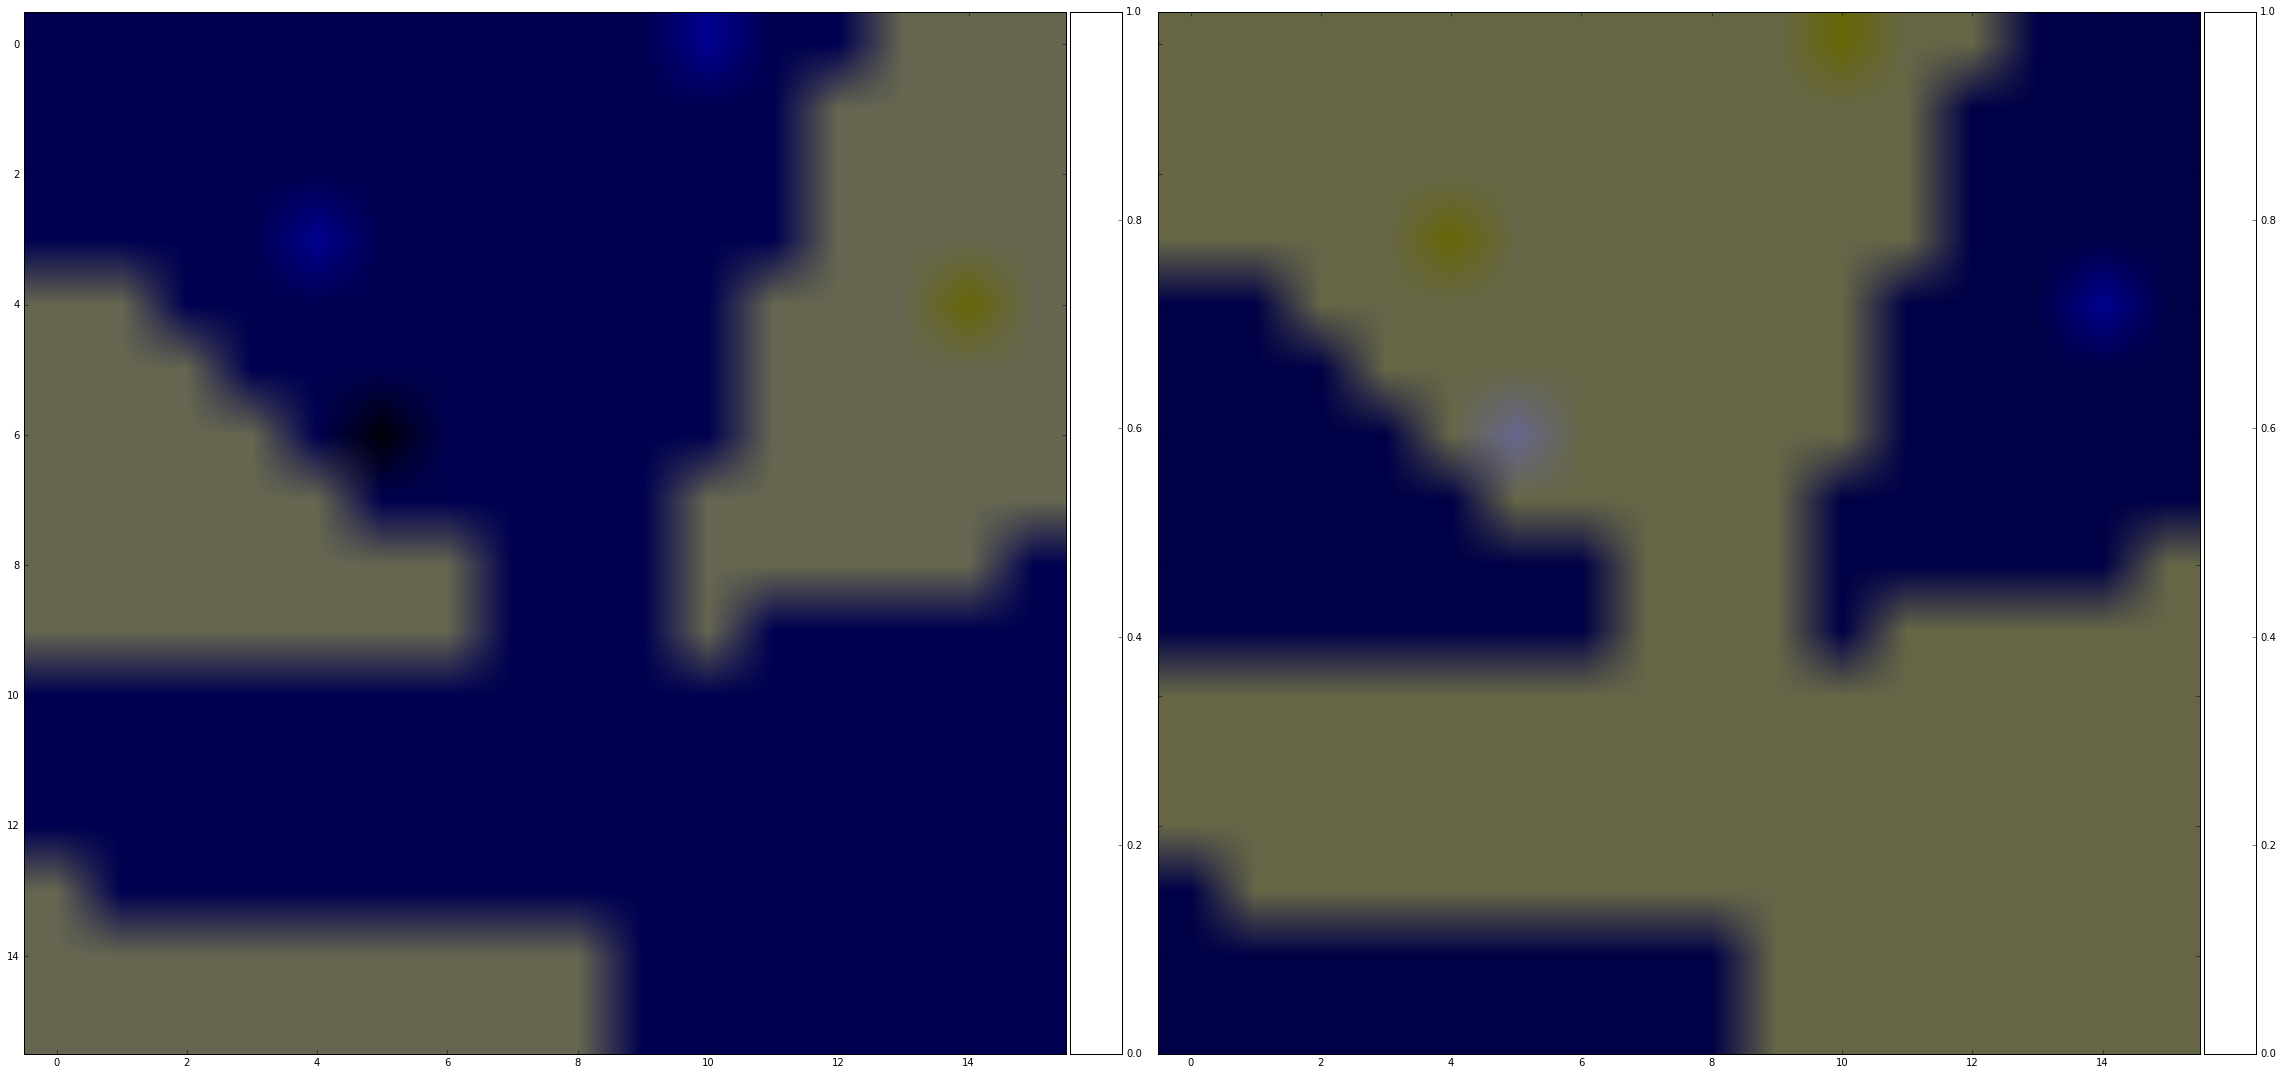

In [37]:

see_posterior_overlay(Q_Z, test_Z)

/home/tnaselar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


array([[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

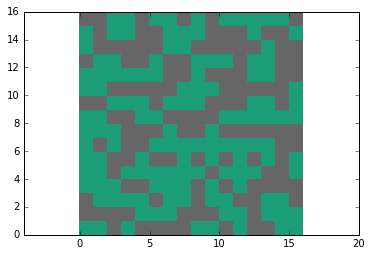

In [38]:
see_Z_sample(Z[1], sqrt_D)

In [39]:
see_object_confusion(Q_Z, test_Z)

NameError: name 'see_object_confusion' is not defined